# Import libraries

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
# Time Series Forecasting - Multivariate Time Series Models for Stock Market Prediction

import math  
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime 
from pandas.plotting import register_matplotlib_converters 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential 
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import RobustScaler, MinMaxScaler
import seaborn as sns 
import yfinance as yf

print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.9.2
Num GPUs: 1


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# Preprocessing

In [ ]:
def load(symbol,start_date,end_date):
  df = yf.download(symbol, start=start_date, end=end_date)
  return df

In [ ]:
def count(start_date,end_date):
  end_date_object = datetime.strptime(end_date, '%Y-%m-%d').date()
  start_date_object = datetime.strptime(start_date, '%Y-%m-%d').date()
  return (end_date_object-start_date_object)

In [ ]:
def plot(df):
  df_plot = df.copy()

  num_cols = 2
  num_rows = int(round(df_plot.shape[1] / num_cols, 0))

  fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, figsize=(20, 10))
  for i, ax in enumerate(fig.axes):
          sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
          ax.tick_params(axis="x", rotation=30, labelsize=15, length=0)
          ax.xaxis.set_major_locator(mdates.AutoDateLocator())
  fig.tight_layout()
  plt.show()

In [ ]:
def preprocess(df, seq_len, split=0.8):
  sequence_length = seq_len
  
  stock_features = ['High', 'Low', 'Open', 'Close', 'Volume']

  train_df = df.sort_values(by=['Date']).copy()

  data = pd.DataFrame(train_df)
  data_filtered = data[stock_features]

  data_filtered_ext = data_filtered.copy()
  data_filtered_ext['Prediction'] = data_filtered_ext['Close']
  nrows = data_filtered.shape[0]
  np_data_unscaled = np.array(data_filtered)
  np_data = np.reshape(np_data_unscaled, (nrows, -1))
  scaler = MinMaxScaler()
  np_data_scaled = scaler.fit_transform(np_data_unscaled)

  scaler_pred = MinMaxScaler()
  df_Close = pd.DataFrame(data_filtered_ext['Close'])
  np_Close_scaled = scaler_pred.fit_transform(df_Close)


  index_Close = data.columns.get_loc("Close")

 
  train_data_len = math.ceil(np_data_scaled.shape[0] *split)

  train_data = np_data_scaled[0:train_data_len, :]
  val_data = np_data_scaled[train_data_len - sequence_length:, :]


  def partition_rnn(sequence_length, data):
      x, y = [], []
      data_len = data.shape[0]
      for i in range(sequence_length, data_len):
          x.append(data[i-sequence_length:i,:]) 
          y.append(data[i, index_Close]) 
      
      x = np.array(x)
      y = np.array(y)
      return x, y

  x_train, y_train = partition_rnn(sequence_length, train_data)
  x_val, y_val = partition_rnn(sequence_length, val_data)

  return stock_features, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_val, y_val


# Build RNN model

In [ ]:
def create_RNN(hidden_units, input_shape, rnn_type, lr, loss, drop=0.2):
  model = Sequential()
  if rnn_type == 'RNN':

    model.add(SimpleRNN(hidden_units, return_sequences=True, input_shape=input_shape)) 
    model.add(Dropout(drop))
    model.add(SimpleRNN(hidden_units, return_sequences=True))
    model.add(SimpleRNN(hidden_units, return_sequences=False))

  elif rnn_type == 'LSTM':

    model.add(LSTM(hidden_units, return_sequences=True, input_shape=input_shape)) 
    model.add(Dropout(drop))
    model.add(LSTM(hidden_units, return_sequences=True))
    model.add(LSTM(hidden_units, return_sequences=False))

  elif rnn_type == 'GRU':

    model.add(GRU(hidden_units, return_sequences=True, input_shape=input_shape)) 
    model.add(Dropout(drop))
    model.add(GRU(hidden_units, return_sequences=True))
    model.add(GRU(hidden_units, return_sequences=False))

  model.add(Dense(1))

  opt = keras.optimizers.Adam(learning_rate=lr)
  model.compile(optimizer=opt, loss=loss)

  return model

In [ ]:
def loss_plot(history, epochs, rnn_type ="Vanilla RNN"):
  fig, ax = plt.subplots(figsize=(12, 5), sharex=True)
  sns.lineplot(data=history.history["loss"])
  sns.lineplot(data=history.history["val_loss"])
  plt.title(f"Loss Curve w/ {rnn_type}")
  plt.ylabel("Loss")
  plt.xlabel("Steps")
  plt.legend(["Train", "Val"], loc="upper left")
  plt.grid()
  plt.show()

In [20]:
def evaluate(model, x_train, y_train, x_val, y_val, scaler_pred, epoch, batch_size): #SimpleRNN_model | LSTM_model | GRU_model
  epochs = epoch
  batch_size = batch_size
  early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
  history = model.fit(x_train, y_train, 
                      batch_size=batch_size, 
                      epochs=epochs,
                      validation_data=(x_val, y_val)
                      #callbacks=[early_stop])
                    )
                      
                      


  y_pred_scaled = model.predict(x_val)
  y_pred = scaler_pred.inverse_transform(y_pred_scaled)
  y_val_unscaled = scaler_pred.inverse_transform(y_val.reshape(-1, 1))

  MAE = mean_absolute_error(y_val_unscaled, y_pred)
  MAPE = np.mean((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled))) * 100
  MDAPE = np.median((np.abs(np.subtract(y_val_unscaled, y_pred)/ y_val_unscaled)) ) * 100
  MSE = mean_absolute_error(y_val_unscaled, y_pred)
  RMSE = np.sqrt(mean_squared_error(y_val_unscaled, y_pred))

  return history, y_pred, MAE, MAPE, MDAPE, MSE, RMSE

In [ ]:
def evaluate_plot(data_filtered_ext, train_data_len, y_pred, stockname, display_start_date = "2019-01-01", rnn_type= "LSTM" ):
  display_start_date = display_start_date
  val = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_val'})
  train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
  val.insert(1, "y_pred", y_pred, True)
  df_union = pd.concat([val,train])

  df_union_zoom = df_union[df_union.index > display_start_date]
  fig, ax1 = plt.subplots(figsize=(12, 5))
  plt.title(f"Stock Price Prediction w/ {rnn_type}")
  plt.ylabel(stockname)
  sns.lineplot(data=df_union_zoom[['y_train',  'y_val', 'y_pred']], linewidth=1.0, dashes=False, ax=ax1)
  plt.grid()
  plt.legend()
  plt.show()

# Stock company

[*********************100%***********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2018-01-02  1750.089966  1790.660034  1744.500000  1784.750000  1784.750000   
2018-01-03  1790.229980  1829.020020  1785.000000  1824.160034  1824.160034   
2018-01-04  1838.540039  1848.900024  1802.030029  1807.250000  1807.250000   
2018-01-05  1820.180054  1825.500000  1805.800049  1823.540039  1823.540039   
2018-01-08  1827.489990  1874.949951  1825.189941  1851.810059  1851.810059   

            Volume  
Date                
2018-01-02  475500  
2018-01-03  525000  
2018-01-04  592600  
2018-01-05  358600  
2018-01-08  555600  
1785 days, 0:00:00


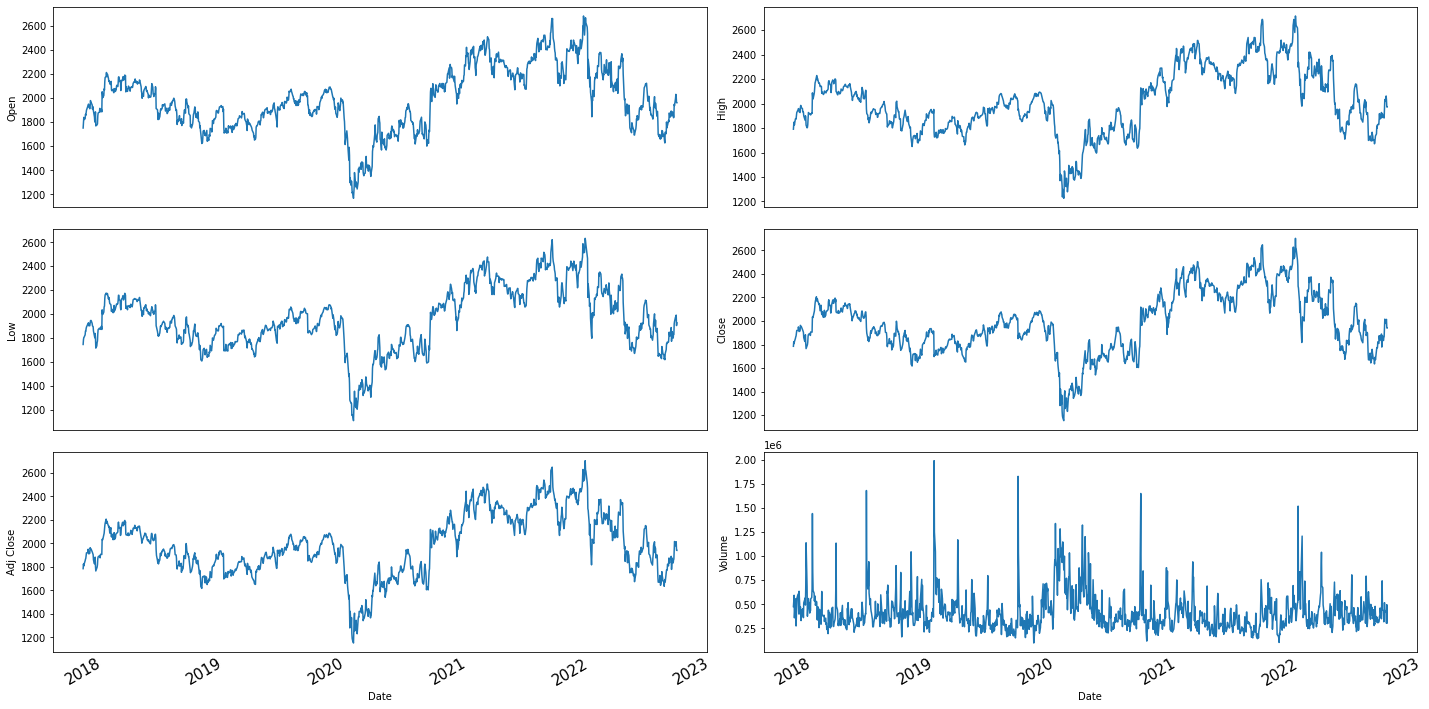

In [ ]:
symbol ='BKNG'
stock_company = 'Booking Holdings Inc'

start_date = '2018-01-01'
end_date =  date.today().strftime("%Y-%m-%d")

df = load(symbol,start_date, end_date)
print(df.head())

print(count(start_date, end_date))

plot(df)

# RNN

In [32]:
sequence_length = 100 #sliding_window 
stock_features, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_val, y_val = preprocess(df, seq_len = sequence_length)
print(train_data_len)
h0 = x_train.shape[1] * x_train.shape[2]

985


In [33]:
epoch=50
batch_size=train_data_len
lr=0.001
loss="mean_squared_error"


SimpleRNN_model = create_RNN(hidden_units = h0, input_shape=(x_train.shape[1], x_train.shape[2]), rnn_type='RNN', lr=lr, loss=loss)

history, y_pred_simplernn, MAE_simplernn, MAPE_simplernn, MDAPE_simplernn, MSE_simplernn, RMSE_simplernn = evaluate(SimpleRNN_model, x_train, y_train, x_val, y_val, scaler_pred, epoch=epoch, batch_size=batch_size)



Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.1519 - val_loss: 30.3507
Epoch 2/50
1/1 [==============================] - 0s 360ms/step - loss: 25.1058 - val_loss: 9.7644
Epoch 3/50
1/1 [==============================] - 0s 355ms/step - loss: 6.4590 - val_loss: 24.9798
Epoch 4/50
1/1 [==============================] - 0s 357ms/step - loss: 24.3213 - val_loss: 1.1033
Epoch 5/50
1/1 [==============================] - 0s 355ms/step - loss: 0.7340 - val_loss: 0.1807
Epoch 6/50
1/1 [==============================] - 0s 368ms/step - loss: 0.2955 - val_loss: 0.6892
Epoch 7/50
1/1 [==============================] - 0s 355ms/step - loss: 0.6837 - val_loss: 0.1341
Epoch 8/50
1/1 [==============================] - 0s 356ms/step - loss: 0.1671 - val_loss: 0.2887
Epoch 9/50
1/1 [==============================] - 0s 364ms/step - loss: 0.2599 - val_loss: 0.9523
Epoch 10/50
1/1 [==============================] - 0s 354ms/step - loss: 1.3712 - val_loss: 3.2678
Epoch 11/50
1/1 [=

In [34]:
SimpleRNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 100, 500)          253000    
                                                                 
 dropout_3 (Dropout)         (None, 100, 500)          0         
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 100, 500)          500500    
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 500)               500500    
                                                                 
 dense_3 (Dense)             (None, 1)                 501       
                                                                 
Total params: 1,254,501
Trainable params: 1,254,501
Non-trainable params: 0
_________________________________________________________________


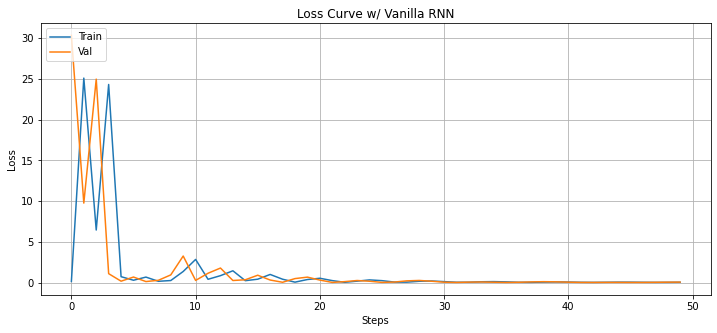

In [35]:
loss_plot(history, epochs=epoch, rnn_type ="Vanilla RNN")


In [36]:
print(MAE_simplernn, MAPE_simplernn, MDAPE_simplernn, MSE_simplernn, RMSE_simplernn)


324.37968581284935 14.498065528693186 14.86980422605354 324.37968581284935 396.6233549538655


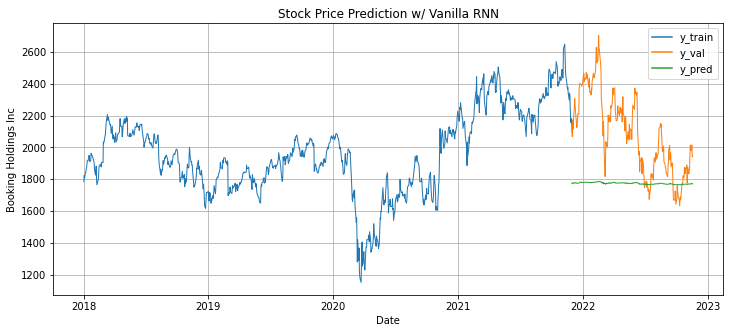

In [37]:
evaluate_plot(data_filtered_ext, train_data_len, y_pred_simplernn, stock_company, display_start_date = start_date, rnn_type ="Vanilla RNN")


# LSTM

In [38]:
sequence_length = 100 #sliding_window 
stock_features, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_test, y_test = preprocess(df, seq_len = sequence_length)
print(train_data_len)
h0 = x_train.shape[1] * x_train.shape[2]

985


In [39]:
epoch=50
batch_size=train_data_len
lr=0.001
loss="mean_squared_error"
LSTM_model = create_RNN(hidden_units = h0, input_shape=(x_train.shape[1], x_train.shape[2]), rnn_type='LSTM',lr=lr, loss=loss)
history, y_pred_LSTM, MAE_LSTM, MAPE_LSTM, MDAPE_LSTM,MSE_LSTM, RMSE_LSTM  = evaluate(LSTM_model, x_train, y_train, x_test, y_test, scaler_pred, epoch=epoch, batch_size=batch_size)


Epoch 1/50
1/1 [==============================] - 9s 9s/step - loss: 0.3103 - val_loss: 0.5005
Epoch 2/50
1/1 [==============================] - 1s 919ms/step - loss: 0.3424 - val_loss: 0.4503
Epoch 3/50
1/1 [==============================] - 1s 850ms/step - loss: 0.3412 - val_loss: 0.3168
Epoch 4/50
1/1 [==============================] - 1s 873ms/step - loss: 0.2431 - val_loss: 0.1468
Epoch 5/50
1/1 [==============================] - 1s 870ms/step - loss: 0.1126 - val_loss: 0.0159
Epoch 6/50
1/1 [==============================] - 1s 869ms/step - loss: 0.0103 - val_loss: 0.2492
Epoch 7/50
1/1 [==============================] - 1s 870ms/step - loss: 0.1711 - val_loss: 0.0135
Epoch 8/50
1/1 [==============================] - 1s 884ms/step - loss: 0.0078 - val_loss: 0.0806
Epoch 9/50
1/1 [==============================] - 1s 876ms/step - loss: 0.0591 - val_loss: 0.1158
Epoch 10/50
1/1 [==============================] - 1s 871ms/step - loss: 0.0860 - val_loss: 0.1065
Epoch 11/50
1/1 [=====

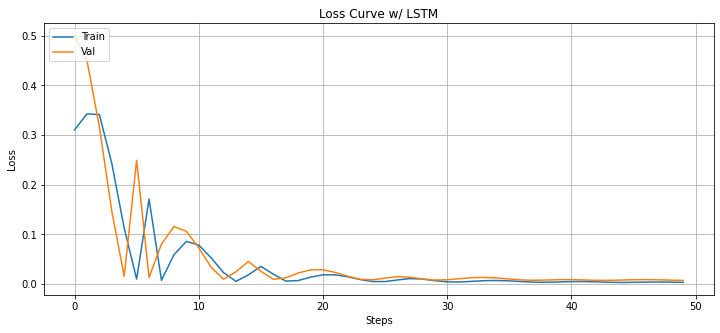

In [40]:
loss_plot(history, epochs=epoch,  rnn_type ="LSTM")


In [41]:
print(MAE_LSTM, MAPE_LSTM, MDAPE_LSTM,MSE_LSTM, RMSE_LSTM)


110.91992137877922 5.310391016530012 4.634036175978426 110.91992137877922 135.14893301646808


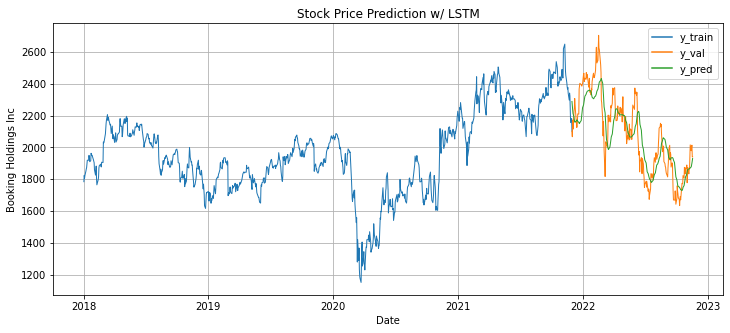

In [42]:
evaluate_plot(data_filtered_ext, train_data_len, y_pred_LSTM, stock_company, display_start_date = start_date) #  "2019-01-01" )


# GRU

In [43]:
sequence_length = 100 #sliding_window 
stock_features, train_data_len, data_filtered_ext, scaler, scaler_pred, index_Close, x_train, y_train, x_val, y_val = preprocess(df, seq_len = sequence_length)

h0 = x_train.shape[1] * x_train.shape[2]


In [44]:
epoch=50
batch_size=train_data_len
lr=0.001
loss="mean_squared_error"

GRU_model = create_RNN(hidden_units = h0, input_shape=(x_train.shape[1], x_train.shape[2]),  rnn_type='GRU',lr=lr, loss=loss)
history, y_pred_GRU, MAE_GRU, MAPE_GRU, MDAPE_GRU,MSE_GRU, RMSE_GRU = evaluate(GRU_model, x_train, y_train, x_val, y_val, scaler_pred, epoch=epoch, batch_size=batch_size)



Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.3074 - val_loss: 0.5528
Epoch 2/50
1/1 [==============================] - 1s 696ms/step - loss: 0.4220 - val_loss: 0.0895
Epoch 3/50
1/1 [==============================] - 1s 715ms/step - loss: 0.0683 - val_loss: 0.2603
Epoch 4/50
1/1 [==============================] - 1s 712ms/step - loss: 0.1999 - val_loss: 0.1780
Epoch 5/50
1/1 [==============================] - 1s 709ms/step - loss: 0.1357 - val_loss: 0.0668
Epoch 6/50
1/1 [==============================] - 1s 721ms/step - loss: 0.0494 - val_loss: 0.0069
Epoch 7/50
1/1 [==============================] - 1s 753ms/step - loss: 0.0040 - val_loss: 0.0293
Epoch 8/50
1/1 [==============================] - 1s 709ms/step - loss: 0.0229 - val_loss: 0.0535
Epoch 9/50
1/1 [==============================] - 1s 715ms/step - loss: 0.0422 - val_loss: 0.0181
Epoch 10/50
1/1 [==============================] - 1s 715ms/step - loss: 0.0143 - val_loss: 0.0051
Epoch 11/50
1/1 [=====

In [45]:
print(MAE_GRU, MAPE_GRU, MDAPE_GRU,MSE_GRU, RMSE_GRU )


68.02018030678353 3.2421916030809697 2.8179463616009066 68.02018030678353 85.0443652050343


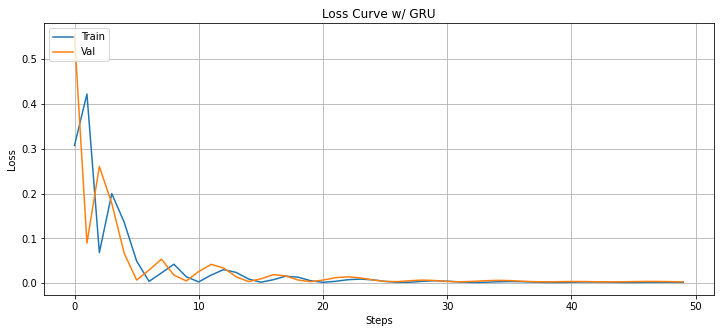

In [46]:
loss_plot(history, epochs=epoch, rnn_type ="GRU")


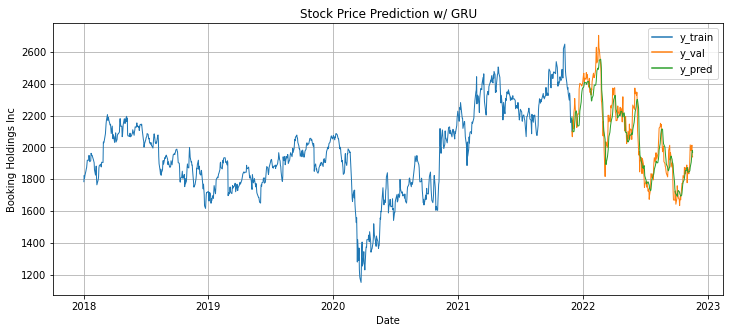

In [47]:
evaluate_plot(data_filtered_ext, train_data_len, y_pred_GRU, stock_company, display_start_date = start_date, rnn_type ="GRU")


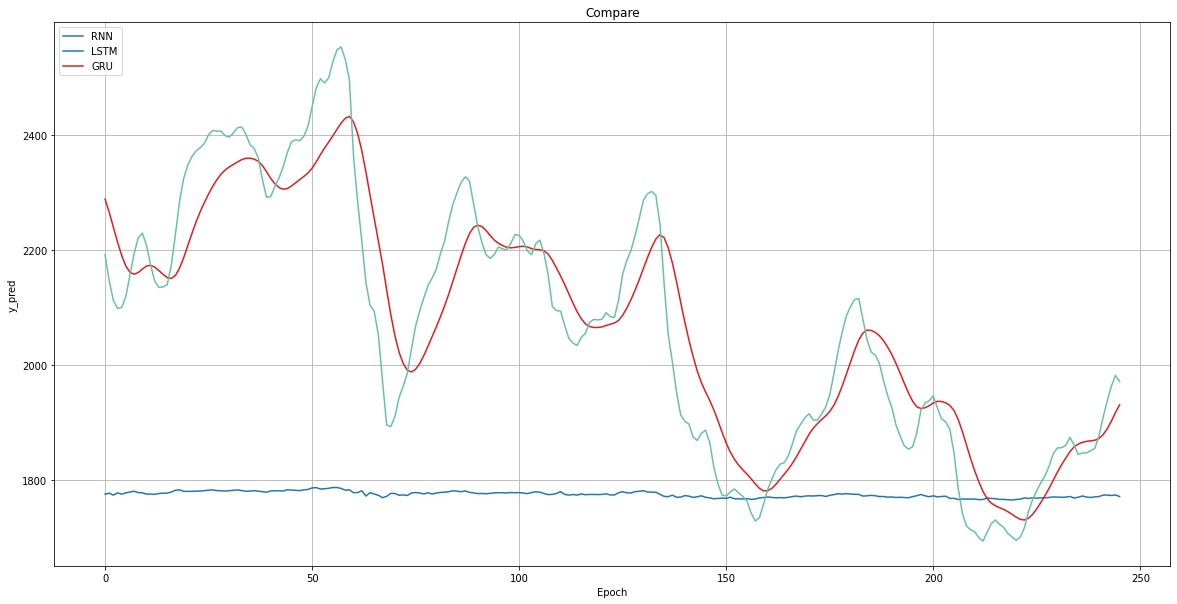

In [48]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=y_pred_simplernn)
sns.lineplot(data=y_pred_LSTM, palette="Set1")
sns.lineplot(data=y_pred_GRU,  palette="Set2")
plt.title("Compare")
plt.ylabel("y_pred")
plt.xlabel("Epoch")
plt.legend(["RNN", "LSTM", "GRU"], loc="upper left")
plt.grid()
plt.show()